In [3]:
!pip install --upgrade osmnx
!pip install codecarbon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.1/610.1 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: termcolor
    Found existing installation: termcolor 3.1.0
    Uninstalling termcolor-3.1.0:
      Successfully uninstalled termcolor-3.1.0
  Attempting uninstall: psutil
    Found existing installation: psutil 5.9.5
    Uninstalling psutil-5.9.5:
      Successfully uninstalled psutil-5.9.5
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully unins

In [4]:
import warnings
import time
import math
import pandas as pd
import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from codecarbon import OfflineEmissionsTracker

Inicializando o monitor de emissões em modo offline para o Brasil...
Iniciando o processo de otimização de rotas...
Baixando o mapa de ruas de Natal/RN...
Mapa baixado e projetado.
Mapeando coordenadas para os nós da malha viária...
Agrupando pontos de coleta para cada agente...
Balanceando os grupos para 5 agentes com 7 pontos e 5 com 6 pontos...
Balanceamento concluído com sucesso.
Pré-calculando a matriz de distâncias com A* (heurística Euclidiana) para 66 nós...
Matriz de distâncias criada.
Calculando a rota para cada um dos 10 agentes...
Gerando caminhos completos para visualização no mapa...

--- Relatório Final ---
Agente 1 (7 pontos): Distância percorrida: 13.61 km
Agente 2 (7 pontos): Distância percorrida: 18.58 km
Agente 3 (7 pontos): Distância percorrida: 46.66 km
Agente 4 (7 pontos): Distância percorrida: 43.72 km
Agente 5 (7 pontos): Distância percorrida: 23.67 km
Agente 6 (6 pontos): Distância percorrida: 32.03 km
Agente 7 (6 pontos): Distância percorrida: 48.73 km
Agente

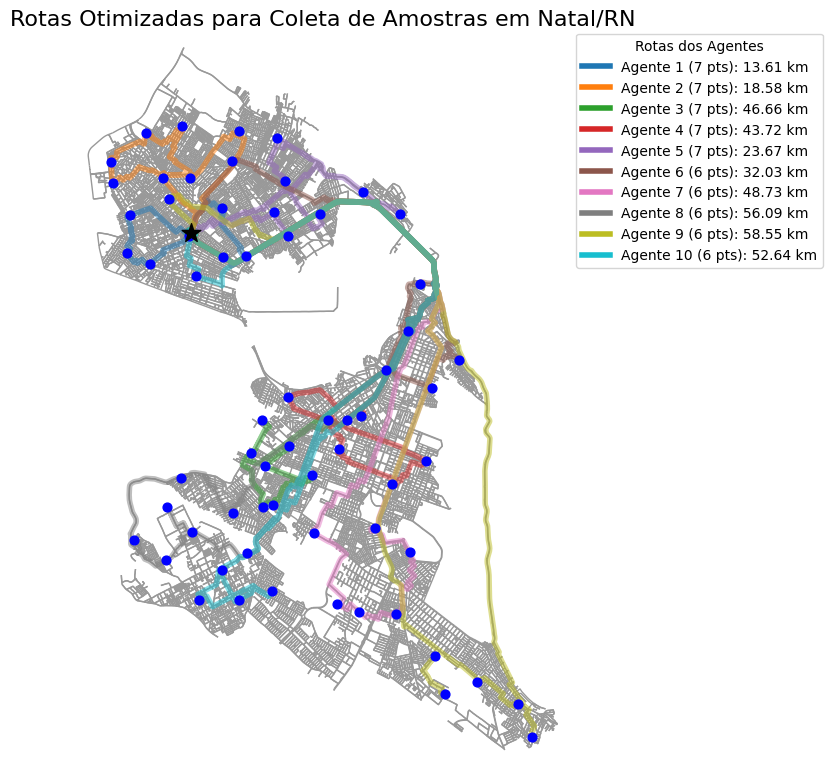

Pegada de Carbono (CodeCarbon):
  - Emissões de CO2: 0.000190 kg CO2eq
  - Consumo de Energia: não disponível


In [3]:

# Ignorar alguns avisos futuros do OSMnx que não são críticos
warnings.filterwarnings("ignore", category=FutureWarning)


# --- INÍCIO DA SEÇÃO MODIFICADA ---

def create_distance_matrix(graph, all_nodes):
    """
    Usa o algoritmo A* com heurística Euclidiana para pré-calcular a distância
    entre todos os pares de nós importantes.
    """

    # Função de heurística (distância em linha reta) para o A*
    # Definida aqui dentro para ter acesso fácil ao 'graph'
    def dist_heuristic(u, v):
        """Calcula a distância Euclidiana entre dois nós do grafo."""
        node_u = graph.nodes[u]
        node_v = graph.nodes[v]
        # Calcula a hipotenusa (distância em linha reta) usando as coordenadas x, y
        return math.hypot(node_u['x'] - node_v['x'], node_u['y'] - node_v['y'])

    dist_matrix = {}
    # Mensagem atualizada para refletir o uso da heurística
    print(f"Pré-calculando a matriz de distâncias com A* (heurística Euclidiana) para {len(all_nodes)} nós...")
    node_pairs = [(u, v) for i, u in enumerate(all_nodes) for v in all_nodes[i:]]

    for u, v in node_pairs:
        try:
            # A chamada agora inclui o parâmetro 'heuristic'
            distance = nx.astar_path_length(graph, u, v, heuristic=dist_heuristic, weight='length')
            dist_matrix[(u, v)] = distance
            dist_matrix[(v, u)] = distance
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            dist_matrix[(u, v)] = float('inf')
            dist_matrix[(v, u)] = float('inf')

    print("Matriz de distâncias criada.")
    return dist_matrix

# --- FIM DA SEÇÃO MODIFICADA ---


def solve_tsp_nearest_neighbor(depot_node, point_nodes, dist_matrix):
    """
    Resolve o Problema do Caixeiro Viajante usando a heurística do "Vizinho mais próximo".
    """
    if not point_nodes:
        return [], 0
    unvisited = list(point_nodes)
    current_node = depot_node
    route = [depot_node]
    total_distance = 0
    while unvisited:
        next_node = min(unvisited, key=lambda node: dist_matrix.get((current_node, node), float('inf')))
        distance = dist_matrix.get((current_node, next_node), float('inf'))
        if distance == float('inf'):
            print(f"Aviso: Não foi possível encontrar um caminho de {current_node} para {next_node}. Interrompendo a rota.")
            break
        total_distance += distance
        route.append(next_node)
        unvisited.remove(next_node)
        current_node = next_node

    # Adiciona o retorno ao depósito
    return_distance = dist_matrix.get((current_node, depot_node), float('inf'))
    if return_distance == float('inf'):
        print(f"Aviso: Não foi possível encontrar um caminho de retorno de {current_node} para o depósito {depot_node}.")
    else:
        total_distance += return_distance
        route.append(depot_node)

    return route, total_distance


def main():
    """
    Função principal para orquestrar a otimização de rotas.
    """
    print("Iniciando o processo de otimização de rotas...")
    start_time = time.time()

    depot_coords = (-5.7536678, -35.2627669) # (Latitude, Longitude)
    place_name = "Natal, Rio Grande do Norte, Brazil"

    try:
        points_df = pd.read_csv('centroid_filtered.csv')
        points_df = points_df.rename(columns={'Lat': 'latitude', 'Lon': 'longitude'})
        if 'latitude' not in points_df.columns or 'longitude' not in points_df.columns:
            raise ValueError("Falha ao renomear colunas. Verifique se 'Lat' e 'Lon' existem no CSV.")
    except FileNotFoundError:
        print("Erro: O arquivo 'centroid_filtered.csv' não foi encontrado.")
        return

    print("Baixando o mapa de ruas de Natal/RN...")
    G = ox.graph_from_place(place_name, network_type='drive')
    G_proj = ox.project_graph(G)
    print("Mapa baixado e projetado.")

    print("Mapeando coordenadas para os nós da malha viária...")
    depot_node = ox.nearest_nodes(G, depot_coords[1], depot_coords[0])
    point_nodes = ox.nearest_nodes(G, points_df['longitude'].values, points_df['latitude'].values)
    points_df['node'] = point_nodes

    print("Agrupando pontos de coleta para cada agente...")
    n_agents = 10
    kmeans = KMeans(n_clusters=n_agents, random_state=42, n_init=10)
    points_df['cluster'] = kmeans.fit_predict(points_df[['latitude', 'longitude']])

    print("Balanceando os grupos para 5 agentes com 7 pontos e 5 com 6 pontos...")
    target_sizes = sorted([7] * 5 + [6] * 5, reverse=True)

    clusters = [points_df[points_df['cluster'] == i].copy() for i in range(n_agents)]

    while True:
        clusters.sort(key=len, reverse=True)
        current_sizes = [len(c) for c in clusters]
        if current_sizes == target_sizes:
            print("Balanceamento concluído com sucesso.")
            break

        source_cluster = clusters[0]
        dest_cluster = clusters[-1]

        dest_centroid = dest_cluster[['latitude', 'longitude']].mean()
        points_to_move = source_cluster[['latitude', 'longitude']] - dest_centroid
        point_to_move_idx = np.linalg.norm(points_to_move.values, axis=1).argmin()
        point_id = source_cluster.index[point_to_move_idx]

        point_row = source_cluster.loc[[point_id]]
        clusters[0] = source_cluster.drop(point_id)
        clusters[-1] = pd.concat([dest_cluster, point_row])

    agent_assignments = [list(c['node']) for c in clusters]

    all_involved_nodes = list(set([depot_node] + list(point_nodes)))
    distance_matrix = create_distance_matrix(G_proj, all_involved_nodes)

    print("Calculando a rota para cada um dos 10 agentes...")
    all_routes_nodes, agent_distances = [], []
    for nodes in agent_assignments:
        route_nodes, distance = solve_tsp_nearest_neighbor(depot_node, nodes, distance_matrix)
        all_routes_nodes.append(route_nodes)
        agent_distances.append(distance)

    print("Gerando caminhos completos para visualização no mapa...")
    all_routes_for_plot = []
    for route in all_routes_nodes:
        if len(route) < 2: continue
        full_path = []
        try:
            for k in range(len(route) - 1):
                path_segment = nx.shortest_path(G_proj, route[k], route[k+1], weight='length')
                full_path.extend(path_segment[:-1])
            full_path.append(route[-1])
            all_routes_for_plot.append(full_path)
        except nx.NetworkXNoPath as e:
            print(f"Aviso: Não foi possível gerar o caminho de plotagem para um segmento da rota: {e}")

    execution_time = time.time() - start_time

    print("\n--- Relatório Final ---")
    for i, dist in enumerate(agent_distances):
        num_pontos = len(agent_assignments[i])
        print(f"Agente {i+1} ({num_pontos} pontos): Distância percorrida: {dist/1000:.2f} km")
    total_distance = sum(agent_distances)
    print(f"\nDistância total percorrida: {total_distance/1000:.2f} km")
    print(f"Tempo total de execução: {execution_time:.2f} segundos.")

    if all_routes_for_plot:
        print("\nGerando o mapa com as rotas...")
        route_colors = ox.plot.get_colors(n=len(all_routes_for_plot), cmap='tab10')
        fig, ax = ox.plot_graph_routes(
            G_proj, all_routes_for_plot, route_colors=route_colors, route_linewidth=2,
            node_size=0, bgcolor='#FFFFFF', show=False, close=False
        )

        depot_x, depot_y = G_proj.nodes[depot_node]['x'], G_proj.nodes[depot_node]['y']
        points_x = points_df.loc[points_df['node'].isin(point_nodes), 'node'].apply(lambda n: G_proj.nodes[n]['x'])
        points_y = points_df.loc[points_df['node'].isin(point_nodes), 'node'].apply(lambda n: G_proj.nodes[n]['y'])

        ax.scatter(points_x, points_y, c='blue', s=40, marker='o', label='Pontos de Coleta', zorder=4)
        ax.scatter(depot_x, depot_y, c='black', s=200, marker='*', label='Centro de Zoonoses', zorder=5)

        legend_elements = [plt.Line2D([0], [0], color=route_colors[i], lw=4, label=f"Agente {i+1} ({len(agent_assignments[i])} pts): {agent_distances[i]/1000:.2f} km") for i in range(len(agent_assignments))]
        ax.legend(
            handles=legend_elements,
            title="Rotas dos Agentes",
            loc='upper left',
            bbox_to_anchor=(1.02, 1),
            borderaxespad=0.
        )

        ax.set_title("Rotas Otimizadas para Coleta de Amostras em Natal/RN", fontsize=16)
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.show()

if __name__ == '__main__':
    print("Inicializando o monitor de emissões em modo offline para o Brasil...")
    tracker = OfflineEmissionsTracker(
        project_name="otimizacao_rotas_final",
        log_level='error',
        country_iso_code="BRA"
    )
    tracker.start()
    try:
        main()
    finally:
        emissions_result = tracker.stop()
        if hasattr(emissions_result, 'emissions'):
            co2_kg = emissions_result.emissions
            energy_kwh = getattr(emissions_result, 'energy_consumed', None)
        else:
            co2_kg = emissions_result
            energy_kwh = None
        print("Pegada de Carbono (CodeCarbon):")
        print(f"  - Emissões de CO2: {co2_kg:.6f} kg CO2eq")
        if energy_kwh is not None:
            print(f"  - Consumo de Energia: {energy_kwh:.6f} kWh")
        else:
            print("  - Consumo de Energia: não disponível")